
# Artificial Intelligence Assignment 3
## Predicting Student Grades
## Parsa Alizadeh 
## 810101572

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
            

## Data Loading and Preprocessing

### Load the dataset, handle missing data, remove irrelevant columns, encode categorical variables, and categorize final grades.

In this part we first do the preprocessing of the data like loading and make it ready to do the process.
we first do the mean and mode imputation to make sure of the data distribution.
Binary encoding handles the yes and no answers. 
We use one-hot encoding to handle nominal variables.
We drop the useless columns like university.

In [3]:

df = pd.read_csv('Grades(1).csv')

# Handle missing data
# 1. Mean imputation for numerical columns
numerical_cols = ['age', 'motherEducation', 'fatherEducation', 'travelTime', 'studyTime', 
                  'failures', 'freeTime', 'goOut', 'Dalc', 'Walc', 'absences', 
                  'EPSGrade', 'DSGrade', 'finalGrade']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# 2. Mode imputation for categorical columns
categorical_cols = ['sex', 'address', 'motherJob', 'fatherJob', 'reason', 
                    'universitySupport', 'paid', 'higher', 'internet', 'romantic']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 3. Forward fill as fallback
df = df.fillna(method='ffill')

# Remove 'university' because it is not realy a variable
df = df.drop('university', axis=1)

# Convert categorical to numerical
# Binary encoding
binary_cols = ['universitySupport', 'paid', 'higher', 'internet', 'romantic']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# One-hot encoding for nominal variables
df = pd.get_dummies(df, columns=['sex', 'address', 'motherJob', 'fatherJob', 'reason'], drop_first=True)

# Categorize finalGrade
def categorize_grade(grade):
    if grade > 17:
        return 'Group A'
    elif 14 <= grade <= 17:
        return 'Group B'
    elif 10 <= grade < 14:
        return 'Group C'
    else:
        return 'Fail'

df['gradeCategory'] = df['finalGrade'].apply(categorize_grade)
df['gradeCategory'] = pd.Categorical(df['gradeCategory'], categories=['Fail', 'Group C', 'Group B', 'Group A'], ordered=True)

# Display first few rows
df.head()


,age,motherEducation,fatherEducation,travelTime,studyTime,failures,universitySupport,paid,higher,internet,...,motherJob_services,motherJob_teacher,fatherJob_health,fatherJob_other,fatherJob_services,fatherJob_teacher,reason_home,reason_other,reason_reputation,gradeCategory
0,18,4,4,2,2,0,1,0,1,0,...,False,False,False,False,False,True,False,False,False,Fail
1,17,1,1,1,2,0,0,0,1,1,...,False,False,False,True,False,False,False,False,False,Fail
2,15,1,1,1,2,3,1,1,1,1,...,False,False,False,True,False,False,False,True,False,Group C
3,15,4,2,1,3,0,0,1,1,1,...,False,False,False,False,True,False,True,False,False,Group B
4,16,3,3,1,2,0,0,1,1,0,...,False,False,False,True,False,False,True,False,False,Group C


## Exploratory Data Analysis

Visualize the dataset to understand distributions and relationships.

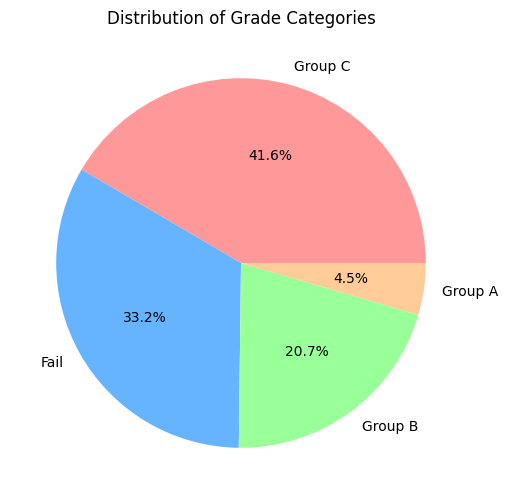

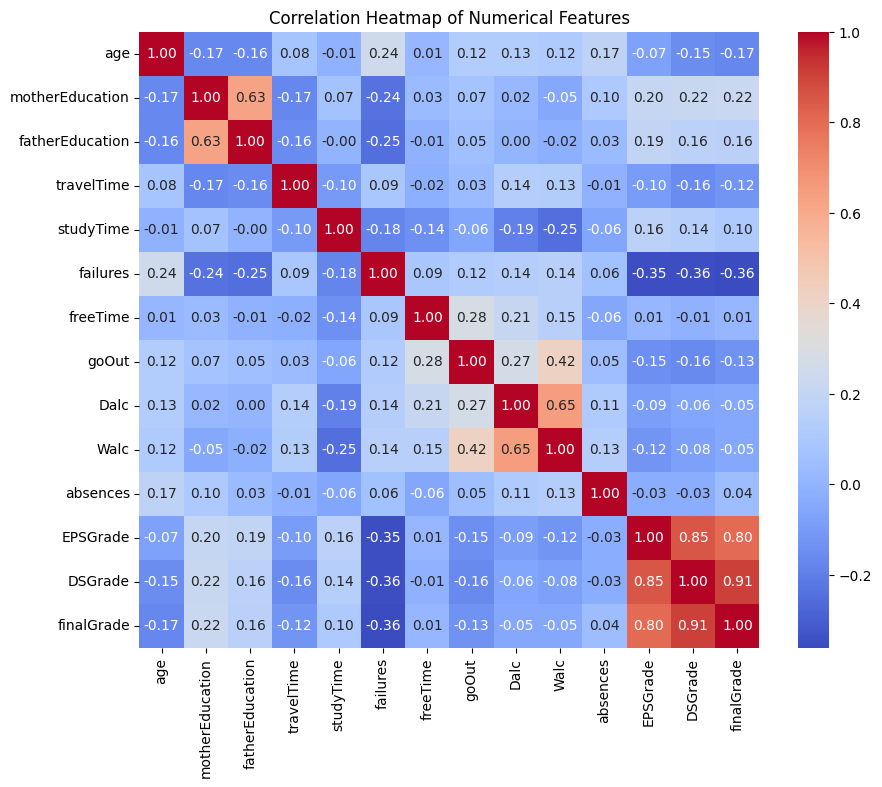

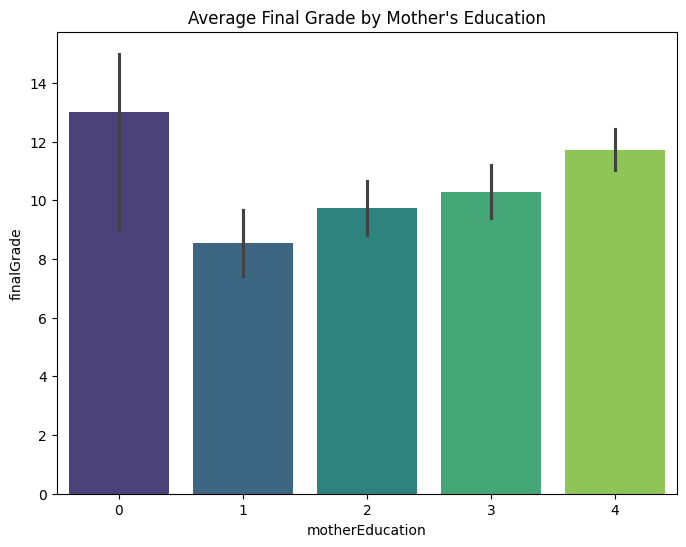

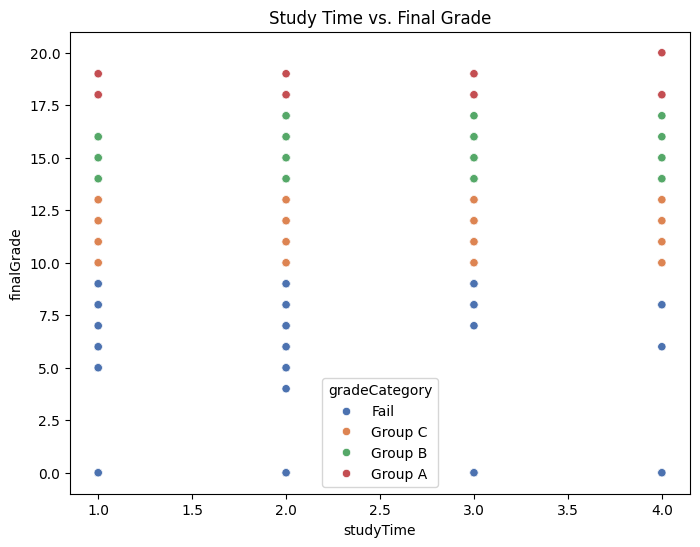

In [4]:
# Grade distribution
plt.figure(figsize=(8, 6))
df['gradeCategory'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribution of Grade Categories')
plt.ylabel('')
plt.savefig('grade_distribution.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('correlation_heatmap.png')
plt.show()

# Average final grade by mother's education
plt.figure(figsize=(8, 6))
sns.barplot(x='motherEducation', y='finalGrade', data=df, palette='viridis')
plt.title('Average Final Grade by Mother\'s Education')
plt.savefig('mother_education_grade.png')
plt.show()

# Study time vs. final grade
plt.figure(figsize=(8, 6))
sns.scatterplot(x='studyTime', y='finalGrade', data=df, hue='gradeCategory', palette='deep')
plt.title('Study Time vs. Final Grade')
plt.savefig('study_time_grade.png')
plt.show()

## Model Development

Split data, standardize features, and train models (Naive Bayes, Decision Tree, Random Forest, XGBoost, Custom Decision Tree).

Dataset size: 397 rows


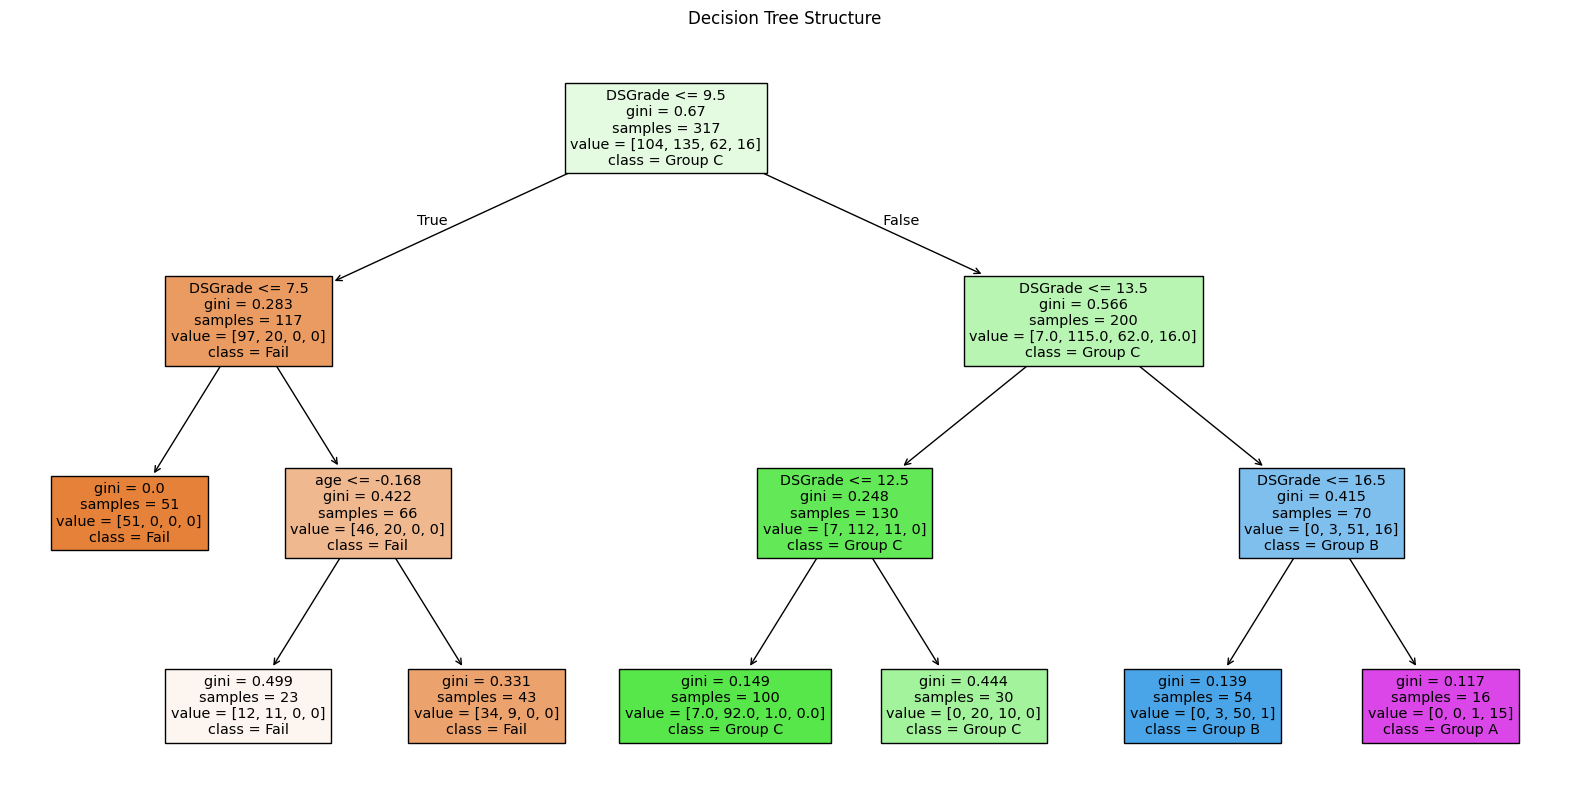

In [5]:
# Prepare features and target
X = df.drop(['finalGrade', 'gradeCategory'], axis=1)
y = df['gradeCategory'].cat.codes  # Encode categories to 0-3

# Check dataset size
print(f"Dataset size: {len(df)} rows")

# Train-test split (adjusted to 80% train, 20% test due to dataset size)
train_size = 0.8
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols[:-3]] = scaler.fit_transform(X_train[numerical_cols[:-3]])
X_test_scaled[numerical_cols[:-3]] = scaler.transform(X_test[numerical_cols[:-3]])

# Dictionary to store results
results = {}

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
results['NaiveBayes'] = classification_report(y_test, y_pred_nb, output_dict=True)

# Decision Tree with GridSearchCV
dt_params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train_scaled, y_train)
y_pred_dt = dt_grid.predict(X_test_scaled)
results['DecisionTree'] = classification_report(y_test, y_pred_dt, output_dict=True)

# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_grid.best_estimator_, feature_names=X.columns, class_names=['Fail', 'Group C', 'Group B', 'Group A'], filled=True)
plt.title('Decision Tree Structure')
plt.savefig('decision_tree.png')
plt.show()

# Random Forest with RandomizedSearchCV
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_grid.fit(X_train_scaled, y_train)
y_pred_rf = rf_grid.predict(X_test_scaled)
results['RandomForest'] = classification_report(y_test, y_pred_rf, output_dict=True)

# XGBoost with GridSearchCV
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_grid.predict(X_test_scaled)
results['XGBoost'] = classification_report(y_test, y_pred_xgb, output_dict=True)

# Custom Decision Tree Implementation
class CustomDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        return entropy(counts, base=2)

    def information_gain(self, X, y, feature, threshold):
        parent_entropy = self.entropy(y)
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0
        left_entropy = self.entropy(y[left_mask])
        right_entropy = self.entropy(y[right_mask])
        n = len(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)
        child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        return parent_entropy - child_entropy

    def find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self.information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if self.max_depth is not None and depth >= self.max_depth:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}
        if len(np.unique(y)) == 1:
            return {'leaf': True, 'class': y[0]}
        
        feature, threshold = self.find_best_split(X, y)
        if feature is None:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}
        
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, node):
        if node['leaf']:
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

# Train and evaluate custom decision tree
custom_dt = CustomDecisionTree(max_depth=5)
custom_dt.fit(X_train_scaled.values, y_train.values)
y_pred_custom = custom_dt.predict(X_test_scaled.values)
results['CustomDecisionTree'] = classification_report(y_test, y_pred_custom, output_dict=True)

## Model Evaluation

Evaluate models using confusion matrix, precision, recall, F1-score, and micro/macro averages.

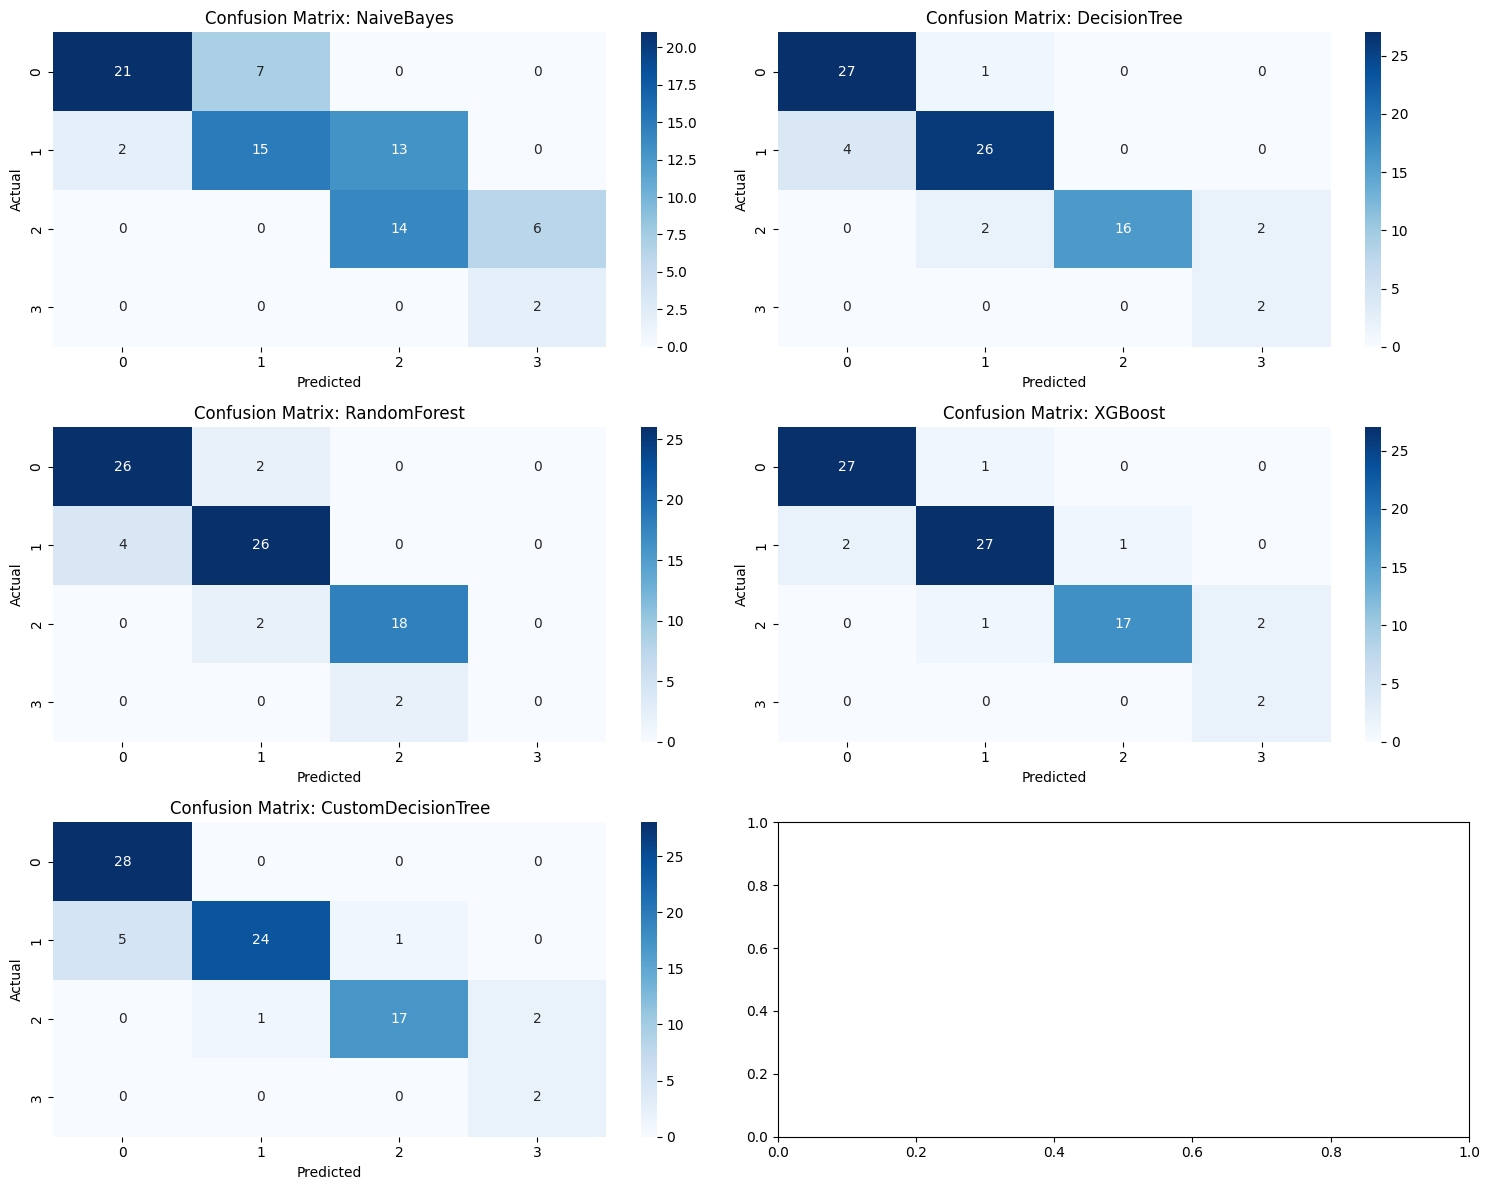


Model: NaiveBayes
Accuracy: 0.65
Macro Avg Precision: 0.59
Macro Avg Recall: 0.74
Macro Avg F1-Score: 0.60

Model: DecisionTree
Accuracy: 0.89
Macro Avg Precision: 0.82
Macro Avg Recall: 0.91
Macro Avg F1-Score: 0.84

Model: RandomForest
Accuracy: 0.88
Macro Avg Precision: 0.66
Macro Avg Recall: 0.67
Macro Avg F1-Score: 0.67

Model: XGBoost
Accuracy: 0.91
Macro Avg Precision: 0.83
Macro Avg Recall: 0.93
Macro Avg F1-Score: 0.86

Model: CustomDecisionTree
Accuracy: 0.89
Macro Avg Precision: 0.81
Macro Avg Recall: 0.91
Macro Avg F1-Score: 0.84


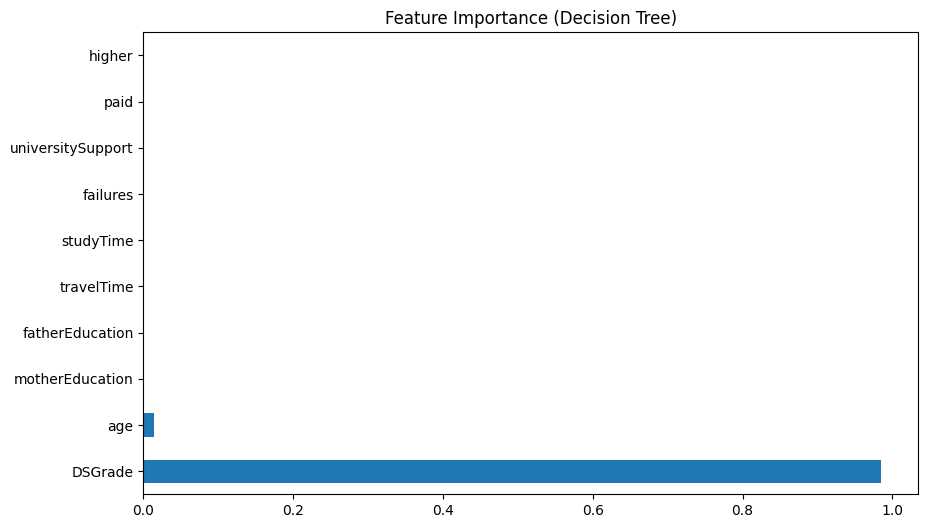

In [6]:
# Evaluation
models = {
    'NaiveBayes': y_pred_nb,
    'DecisionTree': y_pred_dt,
    'RandomForest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'CustomDecisionTree': y_pred_custom
}

# Plot confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()
for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Print classification reports
for name, report in results.items():
    print(f"\nModel: {name}")
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Macro Avg Precision: {report['macro avg']['precision']:.2f}")
    print(f"Macro Avg Recall: {report['macro avg']['recall']:.2f}")
    print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.2f}")

# Feature importance for Decision Tree
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(dt_grid.best_estimator_.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Feature Importance (Decision Tree)')
plt.savefig('feature_importance.png')
plt.show()

## Prediction

Predict the grade for a hypothetical student using the best model (XGBoost).

In [ ]:
# Hypothetical student 
student = pd.DataFrame({
    'age': [18], 'motherEducation': [4], 'fatherEducation': [4], 'travelTime': [1],
    'studyTime': [3], 'failures': [0], 'universitySupport': [1], 'paid': [0],
    'higher': [1], 'internet': [1], 'romantic': [0], 'freeTime': [3], 'goOut': [3],
    'Dalc': [1], 'Walc': [1], 'absences': [2], 'EPSGrade': [15], 'DSGrade': [14],
    'sex_M': [1], 'address_U': [1], 'motherJob_health': [0], 'motherJob_other': [0],
    'motherJob_services': [0], 'motherJob_teacher': [1], 'fatherJob_health': [0],
    'fatherJob_other': [0], 'fatherJob_services': [0], 'fatherJob_teacher': [1],
    'reason_home': [0], 'reason_other': [1], 'reason_reputation': [0]
})

# Standardize
student_scaled = student.copy()
student_scaled[numerical_cols[:-3]] = scaler.transform(student[numerical_cols[:-3]])

# Ensure column order matches training data
student_scaled = student_scaled[X_train_scaled.columns]

# Predict
pred = xgb_grid.predict(student_scaled)
print(f"Predicted Grade Category: {['Fail', 'Group C', 'Group B', 'Group A'][pred[0]]}")

Predicted Grade Category: Group B
